# モチベーション

## 学習目標

- pandas と matplotlib で自由にデータを扱える
- 時系列データの「トレンド」「季節性」「ノイズ」を区別できる
- 1週間先程度の電力需要を簡易モデルで予測できる
- 「電験的な負荷特性」をグラフから読み取れるようになる

# Kaggleの問題理解

[問題](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption)

## 各データセットの意味
アメリカの電力会社ごとにcsvファイルが分かれている。

アメリカの地理には疎いため、早速簡単な表をGPTに作成してもらう。

| 略称 | 会社・地域名（正式名） | 主な州・地域 | 備考 |
|:--|:--|:--|:--|
| **AEP** | American Electric Power | オハイオ州、インディアナ州、ケンタッキー州 | 米国最大級の送電会社。典型的な内陸型負荷。 |
| **COMED** | Commonwealth Edison Company | イリノイ州（シカゴ周辺） | 都市部。日中の変動が大きい。 |
| **DAYTON** | Dayton Power and Light Company | オハイオ州西部 | AEPと同州で相関が高い。 |
| **DEOK** | Duke Energy Ohio/Kentucky | オハイオ州、ケンタッキー州 | 南部寄り。季節性が強め。 |
| **DOM** | Dominion Virginia Power | バージニア州 | 東部沿岸。夏のピークが顕著。 |
| **DUQ** | Duquesne Light Company | ペンシルベニア州（ピッツバーグ周辺） | 工業需要の影響が見られる。 |
| **EKPC** | East Kentucky Power Cooperative | ケンタッキー州 | 農村部を含む。需要変動は緩やか。 |
| **FE** | FirstEnergy | オハイオ州、ペンシルベニア州、ニュージャージー州 | 広域供給。気候差の影響を受けやすい。 |
| **NI** | Northern Indiana Public Service Company | インディアナ州北部 | 工業・商業需要が混在。 |
| **PJME** | PJM East | ニュージャージー州、メリーランド州 | 東部沿岸地域。都市密集地。 |
| **PJMW** | PJM West | オハイオ州、ペンシルベニア州西部 | 中西部寄り。AEPやDAYTONに近い傾向。 |
| **PJM_Load** | PJM全体負荷（System Total） | 東部13州全体 | PJM全体の総需要。ベンチマーク的指標。 |
| **pjm_hourly_est** | 推計版全体負荷（Estimation） | 全域 | 欠損補間などを含む補助データ。 |
| **est_hourly.parquet** | 推定データ（Parquet形式） | 全域 | データサイズ圧縮版。解析補助用。 |

## ヒントになりそうなこと
### 課題からの引用

> このデータセットでできることのアイデア：
> 
> 過去1年分をテストセットに分割し、エネルギー消費量を予測するモデルを構築できるか？
> 
> 時間帯、休日、長期的な傾向におけるエネルギー消費のトレンドを発見できるか？
>
> 季節によって日次トレンドがどのように変化するかを理解する。夏の傾向は冬の傾向とは大きく異なる。


### 負荷特性を表現する3指標
#### 負荷特性(Load Characteristics)

電気分野でいう負荷特性とは

>時間・季節・用途による電力の使われ方の特徴のことを指す。

消費者がどのように電力を使うのかというのを電力会社側が予測しておくことが大切なので、このようなデータ分析に関心が高まるということ。

#### 指標
| 指標 | 数式（定義） | 意味（電験の視点） | データ分析での活用例 | 粒度 | 高い場合 | 低い場合 |
|:--|:--|:--|:--|:--|:--|:--|
| **需要率（Demand Factor）** | 最大需要電力 ÷ 設備容量 | 設備をどの程度使っているかを示す。設備容量に対する最大利用率。 | 地域・年度ごとの設備利用効率の指標として使用。過剰投資の検証にも。 | 年・月単位 | 設備が有効に使われている | 設備が過剰・遊休気味 |
| **不等率（Diversity Factor）** | 各需要家の最大需要合計 ÷ 系統全体の最大需要 | 負荷が同時に発生していない程度を表す。需要家間のピークのずれを示す。 | 地域別・業種別のピーク同期性を評価し、クラスタリング特徴量に利用。 | 地域・系統単位 |ピークが分散、系統が安定 | 同時ピークで負荷集中 |
| **負荷率（Load Factor）** | 平均需要電力 ÷ 最大需要電力 | 時間的な負荷の安定性を示す。高いほど平準化されている。 | 週・月ごとの安定性を特徴量化し、予測モデルの補助変数として利用。 | 日・週・月単位 |需要が安定・平準化 | ピークが尖り、変動が激しい |


[関連ページ](https://e-sysnet.com/%E9%9C%80%E8%A6%81%E7%8E%87%E3%83%BB%E4%B8%8D%E7%AD%89%E7%8E%87%E3%83%BB%E8%B2%A0%E8%8D%B7%E7%8E%87/)


# データ構造の確認

データ期間: 2004-10-01 01:00:00 〜 2018-08-03 00:00:00
総データ数: 121273
列名: ['AEP_MW']


,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


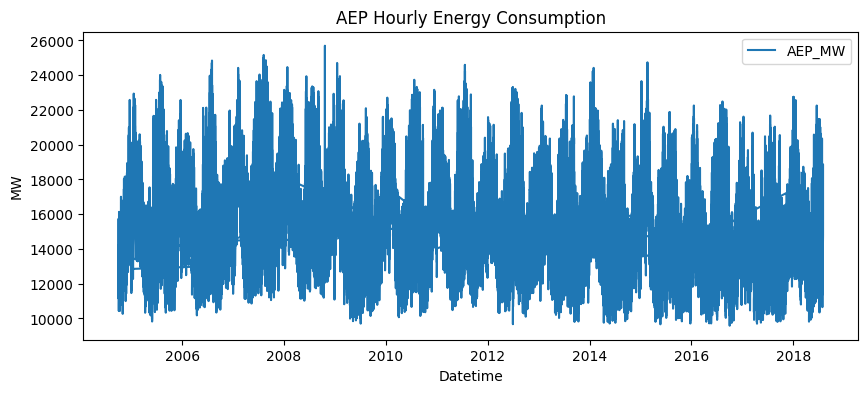

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# 例：AEP_hourly.csv を読み込み
df = pd.read_csv("../data/raw/AEP_hourly.csv")

# 日時列をDatetime型に変換
df["Datetime"] = pd.to_datetime(df["Datetime"])
df = df.set_index("Datetime")

print("データ期間:", df.index.min(), "〜", df.index.max())
print("総データ数:", len(df))
print("列名:", list(df.columns))
display(df.head())

# 時系列プロット
plt.figure(figsize=(10, 4))
plt.plot(df.index, df["AEP_MW"], label="AEP_MW")
plt.title("AEP Hourly Energy Consumption")
plt.xlabel("Datetime")
plt.ylabel("MW")
plt.legend()
plt.show()

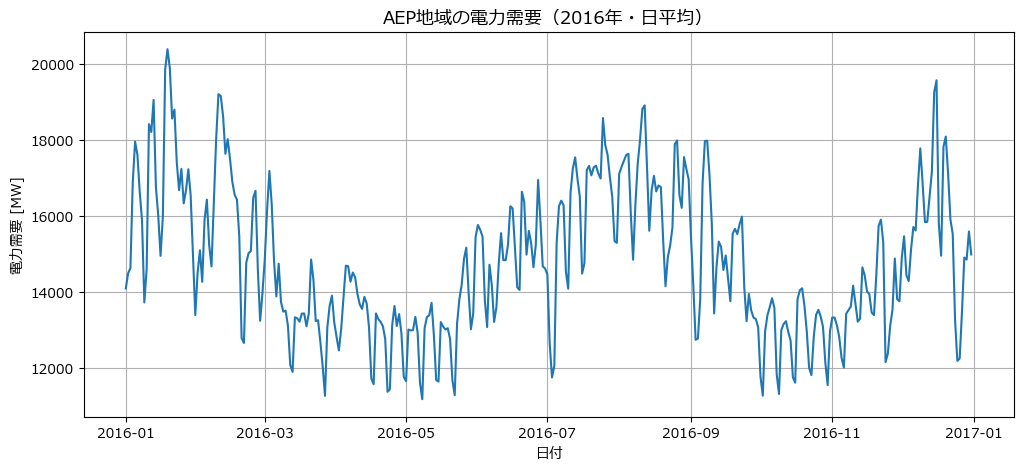

In [5]:
# ===== AEP電力需要：2016年の時系列グラフ（日本語対応版）=====
import pandas as pd
import matplotlib.pyplot as plt

# 日本語フォント設定（Windows）
plt.rcParams['font.family'] = 'Meiryo'
plt.rcParams['axes.unicode_minus'] = False

# データ読み込み
df = pd.read_csv("../data/raw/AEP_hourly.csv", encoding="utf-8")
df.columns = [c.strip() for c in df.columns]
df["Datetime"] = pd.to_datetime(df["Datetime"], errors="coerce")
df = df.dropna(subset=["Datetime"]).sort_values("Datetime").set_index("Datetime")

# 列を特定
ycol = [c for c in df.columns if c.lower().endswith("_mw")][0]

# 2016年のみ抽出
df_2016 = df.loc["2016"]
df_2016_daily = df_2016.resample("D").mean()

# グラフ描画
plt.figure(figsize=(12,5))
plt.plot(df_2016_daily.index, df_2016_daily[ycol], color="tab:blue")
plt.title("AEP地域の電力需要（2016年・日平均）", fontsize=13)
plt.xlabel("日付")
plt.ylabel("電力需要 [MW]")
plt.grid(True)
plt.show()
